# Vehicle Detection

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full  project_video.mp4)  and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

### Import Libraries

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Define Parameters

In [2]:
N_frames_history =[]

In [3]:
def read_image(image):
    return cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    

### Load Training Data

In [4]:
cars = glob.glob('training_images/vehicles/**/*.png')
notcars = glob.glob('training_images/non-vehicles/**/*.png')
print(len(cars), len(notcars))

8792 8968


### Visualize Car and Non Car Data Sample 

Text(0.5,1,'Non Car Image')

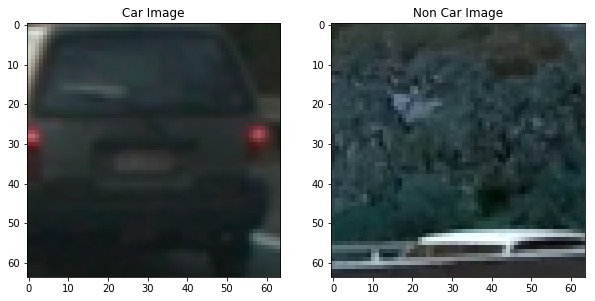

In [5]:
fig, axs = plt.subplots(1,2, figsize=(10, 20))
car_image = read_image(cars[np.random.randint(0,len(cars))])
axs[0].imshow(car_image)
axs[0].set_title("Car Image")
noncar_image = cv2.imread(notcars[np.random.randint(0,len(notcars))])
axs[1].imshow(noncar_image)
axs[1].set_title("Non Car Image")

In [6]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [7]:
image = read_image('./test_images/test1.jpg')
                     
feature_vec = bin_spatial(image, size=(32, 32))

# Plot features
fig = plt.figure(figsize=(11,2))
plt.subplot(121)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(122)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')                    

Text(0.5,1,'Spatially Binned Features')

In [8]:
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:
image = read_image('./test_images/test1.jpg')
                     
feature_vec = color_hist(image,nbins = 16)

# Plot features
fig = plt.figure(figsize=(11,2))
plt.subplot(121)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(122)
plt.plot(feature_vec)
plt.title('Color Histogram')

Text(0.5,1,'Color Histogram')

In [10]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Text(0.5,1,'Non-Car HOG')

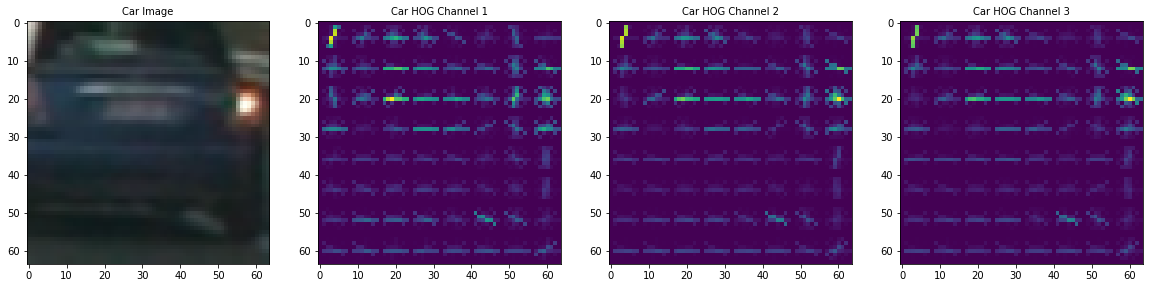

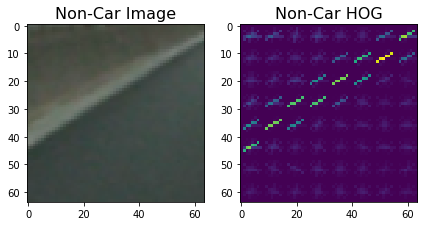

In [11]:
car_image = read_image(cars[1])


car_features1,car_hog_channel1= get_hog_features(car_image[:,:,0], 9, 8, 8, vis=True, feature_vec=True)
car_features2,car_hog_channel2= get_hog_features(car_image[:,:,1], 9, 8, 8, vis=True, feature_vec=True)
car_features3,car_hog_channel3= get_hog_features(car_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

noncar_image = read_image(notcars[1])
noncar_features,noncar_hog_image = get_hog_features(noncar_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, (ax1, ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))
f, (bx1,bx2) = plt.subplots(1, 2, figsize=(7,7))
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(car_hog_channel1)
ax2.set_title('Car HOG Channel 1', fontsize=10)
ax3.imshow(car_hog_channel2)
ax3.set_title('Car HOG Channel 2', fontsize=10)
ax4.imshow(car_hog_channel3)
ax4.set_title('Car HOG Channel 3', fontsize=10)
bx1.imshow(noncar_image)
bx1.set_title('Non-Car Image', fontsize=16)
bx2.imshow(noncar_hog_image)
bx2.set_title('Non-Car HOG', fontsize=16)

In [12]:
def convert_colorspace_v(image,color_space):
    
    if color_space == 'RGB':
        return(cv2.cvtColor(image, cv2.COLOR_RGB2RGB))
    elif color_space == 'HSV':
        return(cv2.cvtColor(image, cv2.COLOR_RGB2HSV))
    elif color_space == 'LUV':
        return(cv2.cvtColor(image, cv2.COLOR_RGB2LUV))
    elif color_space == 'HLS':
        return(cv2.cvtColor(image, cv2.COLOR_RGB2HLS))
    elif color_space == 'YUV':
        return(cv2.cvtColor(image, cv2.COLOR_RGB2YUV))
    elif color_space == 'YCrCb':
        #print(color_space)
        return(cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb))
    else: 
        return(image) 


In [21]:
def extract_features(imgs, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = read_image(file)
        # apply color conversion if other than 'RGB'
        
        feature_image = convert_colorspace_v(image, color_space)
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
                features.append(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                features.append(hog_features)

    # Return list of feature vectors
    return features
    

### Explore Test Accuracy for Different Spatial Bins

In [14]:

color_space = 'YUV' #['RGB','HSV','HLS','YUV', 'YCrCb']
orient = 9  
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = 0 
spatial_sizes = [(16, 16),(32,32)] 
hist_bins = 16    
spatial_feat = True 
hist_feat = False 
hog_feat = False 


t=time.time()

for spatial_size in spatial_sizes:
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print("Colorspace :",color_space)
    print(round(t2-t, 2), 'Seconds to extract Spatial features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    if hog_feat:
        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
    elif spatial_feat:
        print("Using Spatial  Size :",spatial_size)
    elif hist_feat:
        print("Using Histogram Bins:",hist_bins)
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Colorspace : YUV
4.15 Seconds to extract Spatial features...
Using Spatial  Size : (16, 16)
Feature vector length: 768
15.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9285
My SVC predicts:  [1. 1. 0. 1. 0. 1. 1. 0. 1. 1.]
For these 10 labels:  [1. 1. 0. 1. 0. 1. 1. 0. 1. 1.]
0.00111 Seconds to predict 10 labels with SVC
Colorspace : YUV
4.09 Seconds to extract Spatial features...
Using Spatial  Size : (32, 32)
Feature vector length: 3072
26.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9017
My SVC predicts:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
For these 10 labels:  [0. 1. 1. 0. 1. 0. 1. 0. 0. 1.]
0.00115 Seconds to predict 10 labels with SVC


### Explore Test Accuracy for Different Histogram Bins for Spatial bin size 32

In [15]:

color_space = 'YUV'#['RGB','HSV','HLS','YUV', 'YCrCb']
orient = 9  
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = 0 
spatial_size = (32, 32) 
hist_bin = [16,32]    
spatial_feat = False 
hist_feat = True 
hog_feat = False 


t=time.time()

for hist_bins in hist_bin:
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print("Colorspace :",color_space)
    print(round(t2-t, 2), 'Seconds to extract Histogram features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    if hog_feat:
        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
    elif spatial_feat:
        print("Using Spatial Size :",spatial_size)
    elif hist_feat:
        print("Using Histogram Bins:",hist_bins)
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    

Colorspace : YUV
14.33 Seconds to extract Histogram features...
Using Histogram Bins: 16
Feature vector length: 48
2.49 Seconds to train SVC...
Test Accuracy of SVC =  0.8775
My SVC predicts:  [0. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
For these 10 labels:  [0. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
0.0015 Seconds to predict 10 labels with SVC
Colorspace : YUV
13.91 Seconds to extract Histogram features...
Using Histogram Bins: 32
Feature vector length: 96
3.61 Seconds to train SVC...
Test Accuracy of SVC =  0.906
My SVC predicts:  [0. 1. 0. 0. 1. 1. 0. 1. 0. 1.]
For these 10 labels:  [0. 1. 0. 0. 1. 1. 0. 1. 0. 0.]
0.0009 Seconds to predict 10 labels with SVC


### Explore Test Accuracy for Different Color Spaces for Spatial bin size 32 and Hist Bins 32

In [16]:

colorspaces = ['HSV','HLS','YUV', 'YCrCb']
orient = 9  
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = 0 
spatial_size = (32, 32) 
hist_bins = 32    
spatial_feat = True 
hist_feat = True 
hog_feat = False 


t=time.time()

for color_space in colorspaces:
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print("Colorspace :",color_space)
    print(round(t2-t, 2), 'Seconds to extract Color and Spatial features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    if hog_feat:
        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
    elif hist_feat and spatial_feat:
        print("Using Spatial Size :",spatial_size, "and using Histogram Bins:",hist_bins)    
    elif spatial_feat:
        print("Using Spatial Size :",spatial_size)
    elif hist_feat:
        print("Using Histogram Bins:",hist_bins)

    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    

Colorspace : HSV
15.06 Seconds to extract Color and Spatial features...
Using Spatial Size : (32, 32) and using Histogram Bins: 32
Feature vector length: 3168
17.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9383
My SVC predicts:  [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
For these 10 labels:  [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
0.00161 Seconds to predict 10 labels with SVC
Colorspace : HLS
15.65 Seconds to extract Color and Spatial features...
Using Spatial Size : (32, 32) and using Histogram Bins: 32
Feature vector length: 3168
17.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9355
My SVC predicts:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
For these 10 labels:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
0.001 Seconds to predict 10 labels with SVC
Colorspace : YUV
14.33 Seconds to extract Color and Spatial features...
Using Spatial Size : (32, 32) and using Histogram Bins: 32
Feature vector length: 3168
14.46 Seconds to train SVC...
Test Accuracy of SVC =  0.955
My SVC predicts:  [0. 0. 0. 1. 1. 1. 1. 0. 

### Explore Hog Reults for Different Orientation Values

In [17]:

color_space = 'YUV'
orients = [9,10,11]  
pix_per_cell = 8 
cell_per_block = 2 
hog_channel = 'ALL' 
spatial_size = (32, 32) 
hist_bins = 32    
spatial_feat = False 
hist_feat = False 
hog_feat = True 


t=time.time()

for orient in orients:
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print("Colorspace :",color_space)
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    if hog_feat:
        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
    elif hist_feat and spatial_feat:
        print("Using Spatial Size :",spatial_size, "and using Histogram Bins:",hist_bins)    
    elif spatial_feat:
        print("Using Spatial Size :",spatial_size)
    elif hist_feat:
        print("Using Histogram Bins:",hist_bins)

    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



Colorspace : YUV
133.82 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
13.05 Seconds to train SVC...
Test Accuracy of SVC =  0.9865
My SVC predicts:  [0. 0. 1. 0. 1. 0. 0. 0. 1. 1.]
For these 10 labels:  [0. 0. 1. 0. 1. 0. 0. 0. 1. 1.]
0.00107 Seconds to predict 10 labels with SVC
Colorspace : YUV
140.03 Seconds to extract HOG features...
Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5880
3.82 Seconds to train SVC...
Test Accuracy of SVC =  0.9927
My SVC predicts:  [1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
For these 10 labels:  [1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
0.00174 Seconds to predict 10 labels with SVC
Colorspace : YUV
143.05 Seconds to extract HOG features...
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6468
11.08 Seconds to train SVC...
Test Accuracy of SVC =  0.9848
My SVC predicts:  [1. 1. 1. 0. 1. 0. 0. 1. 1. 0.]
For these 10 labels

### Explore Hog Results for Different Pixel per Cell Values with Orientation Value 11 and Hog Channel -ALL

In [19]:

color_space = 'YUV'
orient = 11  
pix_per_cells = [8,16]
cell_per_block = 2 
hog_channel = 'ALL' 
spatial_size = (16, 16) 
hist_bins = 16    
spatial_feat = False 
hist_feat = False
hog_feat = True 


t=time.time()

for pix_per_cell in pix_per_cells:
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print("Colorspace :",color_space)
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    if hog_feat:
        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
    elif hist_feat and spatial_feat:
        print("Using Spatial Size :",spatial_size, "and using Histogram Bins:",hist_bins)    
    elif spatial_feat:
        print("Using Spatial Size :",spatial_size)
    elif hist_feat:
        print("Using Histogram Bins:",hist_bins)

    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



Colorspace : YUV
154.74 Seconds to extract HOG features...
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6468
21.54 Seconds to train SVC...
Test Accuracy of SVC =  0.987
My SVC predicts:  [1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
For these 10 labels:  [1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
0.00229 Seconds to predict 10 labels with SVC
Colorspace : YUV
62.22 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
1.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9879
My SVC predicts:  [1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
For these 10 labels:  [1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
0.00252 Seconds to predict 10 labels with SVC


### Explore Accuracy for Spatial Bin 32,Hist Bin 32,Colorspace YUV,Orientation 11,Pixel per cell 16

In [20]:

color_space = 'YUV'
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


t=time.time()


car_features = extract_features(cars, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print("Colorspace :",color_space)
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

if hog_feat and hist_feat and spatial_feat:
    print("Using Spatial Size :",spatial_size, "and using Histogram Bins:",hist_bins)
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
elif hog_feat:
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
elif hist_feat and spatial_feat:
    print("Using Spatial Size :",spatial_size, "and using Histogram Bins:",hist_bins)    
elif spatial_feat:
    print("Using Spatial Size :",spatial_size)
elif hist_feat:
    print("Using Histogram Bins:",hist_bins)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



Colorspace : YUV
68.06 Seconds to extract HOG features...
Using Spatial Size : (32, 32) and using Histogram Bins: 32
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356
8.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9924
My SVC predicts:  [0. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
For these 10 labels:  [0. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
0.00273 Seconds to predict 10 labels with SVC


### Explore Accuracy for HOG.Color Space YUV,Orient = 11,Pix per cell = 16,Hog Channel = All,

In [22]:
color_space = 'YUV'
orient = 11  
pix_per_cell = 16
cell_per_block = 2 
hog_channel = 'ALL' 
spatial_size = (16, 16) 
hist_bins = 16    
spatial_feat = False 
hist_feat = False
hog_feat = True 


t=time.time()

car_features = extract_features(cars, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print("Colorspace :",color_space)
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

if hog_feat:
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
elif hist_feat and spatial_feat:
    print("Using Spatial Size :",spatial_size, "and using Histogram Bins:",hist_bins)    
elif spatial_feat:
    print("Using Spatial Size :",spatial_size)
elif hist_feat:
    print("Using Histogram Bins:",hist_bins)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



Colorspace : YUV
70.85 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
1.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [0. 1. 1. 1. 0. 1. 0. 1. 1. 0.]
For these 10 labels:  [0. 1. 1. 1. 0. 1. 0. 1. 1. 0.]
0.00183 Seconds to predict 10 labels with SVC


### Method to Detect Cars in an Image for particular Window Area

In [23]:
def find_cars(img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):

    rectangleBox=[]
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_colorspace_v(img_tosearch, colorspace)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
         
            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangleBox.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return rectangleBox

In [24]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

9 rectangles found in image
4 rectangles found in image
3 rectangles found in image
1 rectangles found in image
1 rectangles found in image
6 rectangles found in image
3 rectangles found in image
3 rectangles found in image
2 rectangles found in image
1 rectangles found in image
2 rectangles found in image
5 rectangles found in image
3 rectangles found in image
1 rectangles found in image
0 rectangles found in image
4 rectangles found in image
4 rectangles found in image
4 rectangles found in image
1 rectangles found in image
0 rectangles found in image
1 rectangles found in image
1 rectangles found in image
0 rectangles found in image
0 rectangles found in image
0 rectangles found in image
1 rectangles found in image
0 rectangles found in image
0 rectangles found in image
0 rectangles found in image
0 rectangles found in image


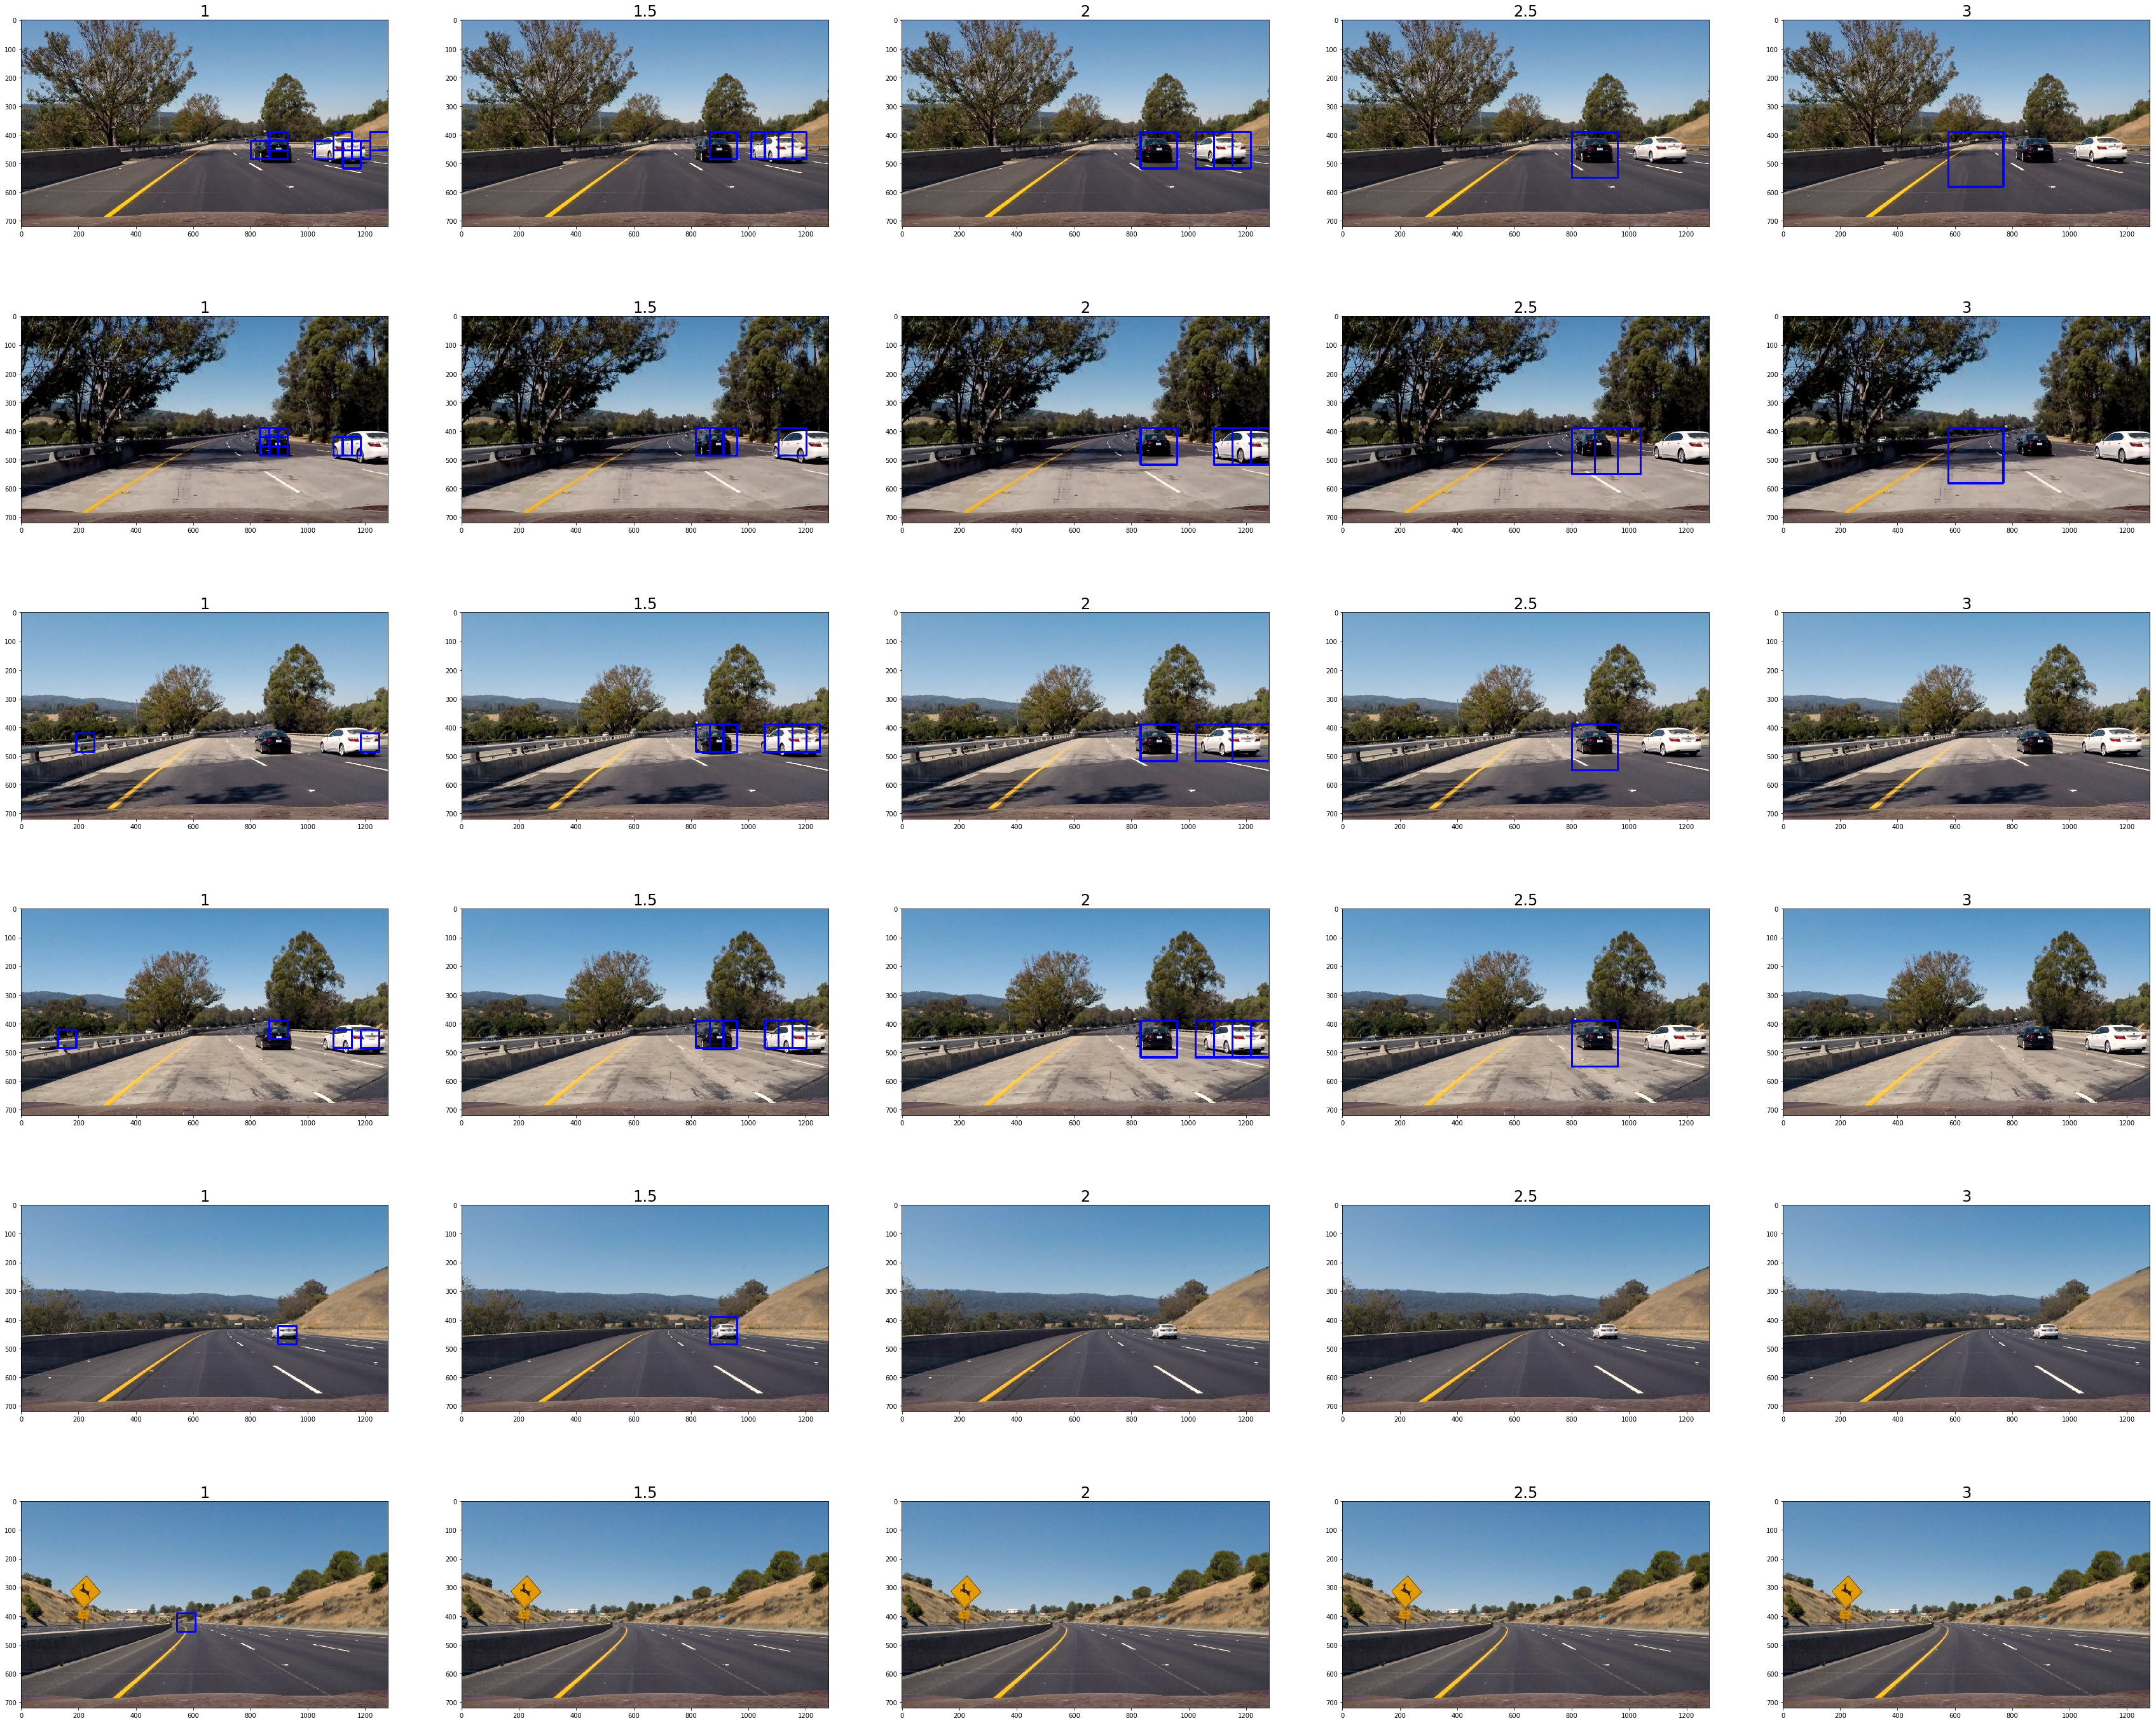

In [26]:
test_imgs = glob.glob('./test_images/test*.jpg')
fg, ax = plt.subplots(6, 5, figsize=(60, 50))
ax = ax.ravel()
i = 0

for image in test_imgs:
    test_img = read_image(image)
    ystart = 390
    ystop = 654
    scales = [1,1.5, 2, 2.5,3]

    
    colorspace = 'YUV' 
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2


    for scale in scales:
        Boxes = find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None )
        outimg=draw_boxes(test_img,Boxes)
        print(len(Boxes), 'rectangles found in image')
        ax[i].imshow(outimg)
        ax[i].set_title(scale, fontsize=24)
        i = i + 1

### Creating Heatmaps to Reduce False Positives and Multiple Detections

In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(labels):
    rectBox = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        rectBox.append((bbox[0], bbox[1]))
    # Return the image
    return rectBox

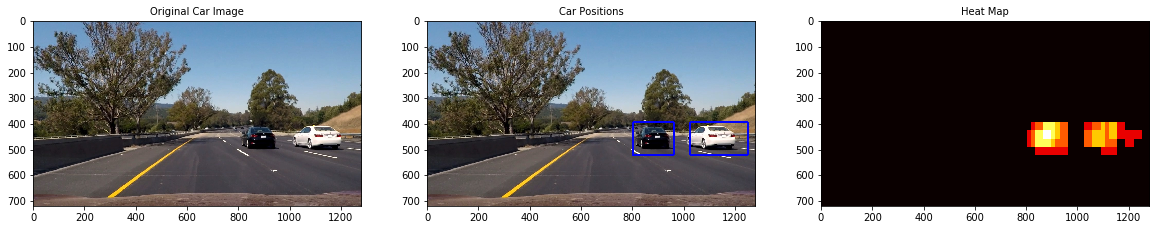

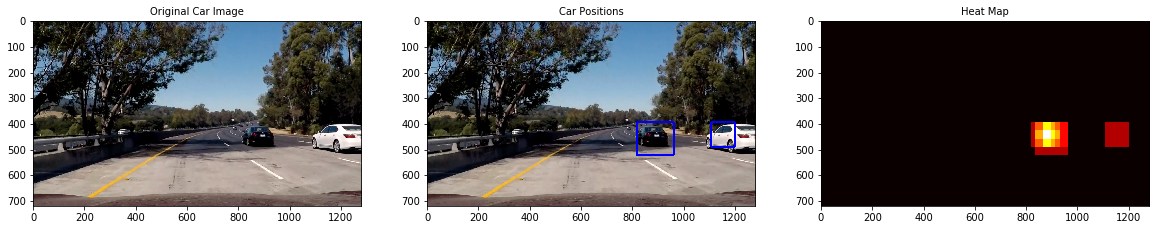

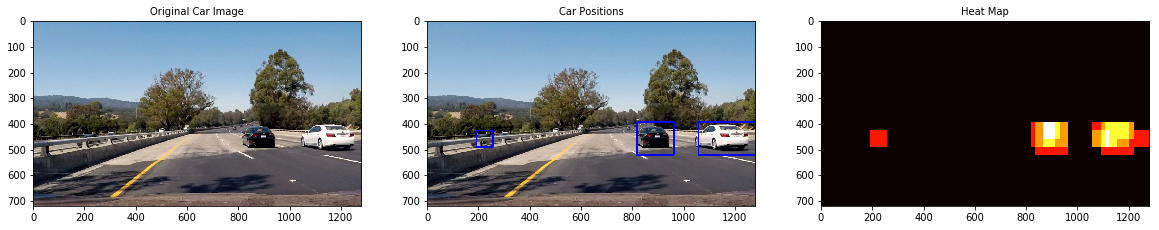

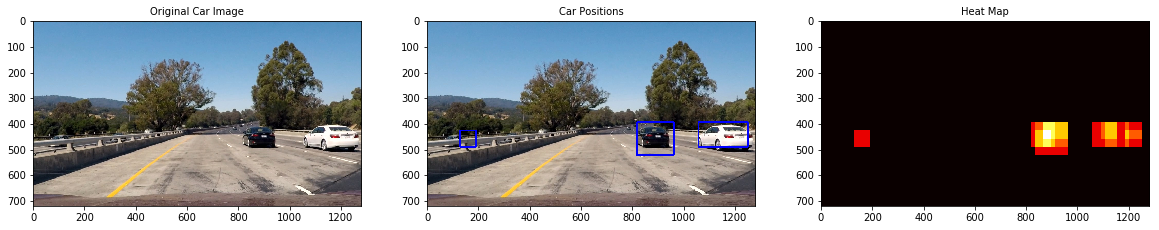

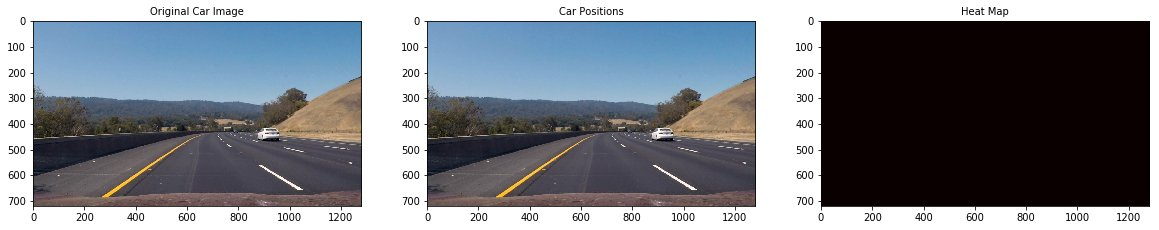

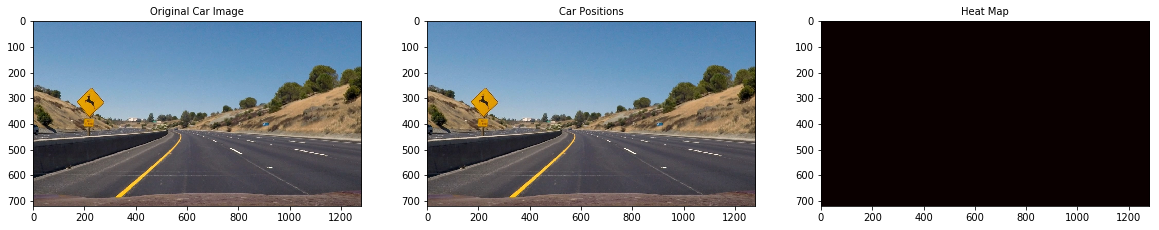

In [34]:

test_imgs = glob.glob('./test_images/test*.jpg')


i = 0
colorspace = 'YUV' 
orient = 11
pix_per_cell = 16
cell_per_block = 2
spatial_size = None 
hist_bins = None
for image in test_imgs:
    test_img = read_image(image)
    

    rectangleBoxes=[]

    ystart = 394 
    ystop = 650 
    scale = 1.0
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))

    ystart = 394 
    ystop = 650 
    scale = 1.5
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))

    ystart = 394
    ystop = 586
    scale = 2
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))

    ystart = 394
    ystop = 586
    scale = 2.5
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))


    ystart = 394
    ystop = 490
    scale = 3
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))


    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    for box in rectangleBoxes:
        heat = add_heat(heat,box)

    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat,0,255)
    labels = label(heatmap)
    
    labeled_boxes = draw_labeled_bboxes(labels)
    draw_img=draw_boxes(test_img,labeled_boxes)

    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,20))

    ax1.imshow(test_img)
    ax1.set_title('Original Car Image', fontsize=10)
    ax2.imshow(draw_img)
    ax2.set_title('Car Positions', fontsize=10)
    ax3.imshow(heatmap, cmap='hot')
    ax3.set_title('Heat Map', fontsize=10)




In [35]:
def process_image(test_img):
    colorspace = 'YUV' 
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    spatial_size = None
    hist_bins = None

    rectangleBoxes=[]
    global N_frames_history

    
    
    ystart = 394 
    ystop = 650 
    scale = 1.0
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))

    ystart = 394 
    ystop = 650 
    scale = 1.5
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))


    ystart = 394 
    ystop = 586 
    scale = 2.0
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))


    ystart = 394 
    ystop = 586 
    scale = 2.5
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))


    ystart = 394 
    ystop = 490 
    scale = 3 
    rectangleBoxes.append(find_cars(test_img,colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,None ,None ))

     
    N_frames_history.append(rectangleBoxes)
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float) 
              
     
    if len(N_frames_history) >= 15:
        del N_frames_history[0]
       
    
    
    for frame in N_frames_history:
        for box in frame:
            if(len(box) != 0):
                heat = add_heat(heat,box)

    heat = apply_threshold(heat,10)
    heatmap = np.clip(heat,0,255)
    labels = label(heatmap)
    
    #draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    labeled_boxes = draw_labeled_bboxes(labels)
    draw_img=draw_boxes(test_img,labeled_boxes)

    return draw_img

In [36]:
while ((len(N_frames_history) > 0)):
    del N_frames_history[0]
print(N_frames_history)

output = 'testVideoOut.mp4'
clip1 = VideoFileClip("test_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[]
[MoviePy] >>>> Building video testVideoOut.mp4
[MoviePy] Writing video testVideoOut.mp4


 97%|█████████▋| 38/39 [01:59<00:03,  3.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testVideoOut.mp4 

CPU times: user 2min 1s, sys: 1.69 s, total: 2min 2s
Wall time: 2min


In [37]:
while ((len(N_frames_history) > 0)):
    del N_frames_history[0]
print(N_frames_history)

output = 'ProjVideoOut.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[]
[MoviePy] >>>> Building video ProjVideoOut.mp4
[MoviePy] Writing video ProjVideoOut.mp4


100%|█████████▉| 1260/1261 [1:04:00<00:03,  3.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ProjVideoOut.mp4 

CPU times: user 1h 5min 8s, sys: 46.8 s, total: 1h 5min 55s
Wall time: 1h 4min 2s
